Files already downloaded and verified
人物（仮）の画像数: 5000
Epoch 1, Loss: 138.5813
Epoch 2, Loss: 102.3809
Epoch 3, Loss: 92.4223
Epoch 4, Loss: 86.3213
Epoch 5, Loss: 80.2225
Epoch 6, Loss: 74.5401
Epoch 7, Loss: 71.9045
Epoch 8, Loss: 70.3809
Epoch 9, Loss: 69.3954
Epoch 10, Loss: 68.4445


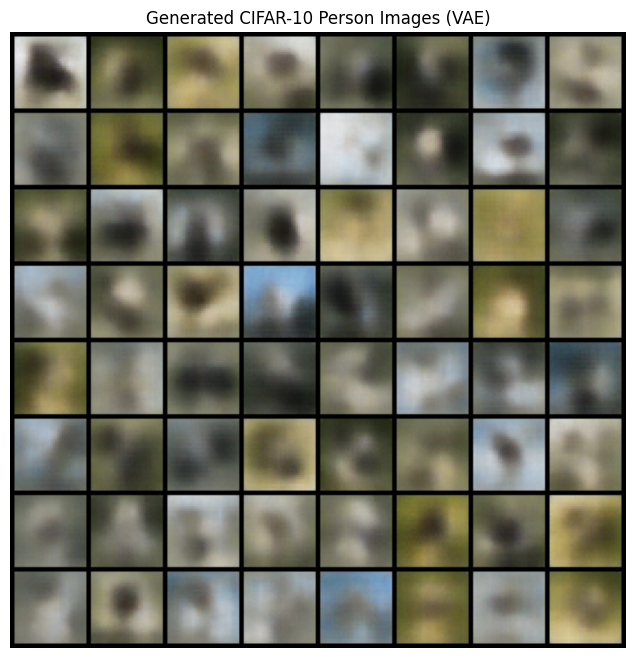

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# デバイス設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-10から人物画像だけ抽出
transform = transforms.Compose([
    transforms.ToTensor(),
])

cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# クラス番号 1 が "automobile", 2 が "bird", ..., 6 が "frog", 7 が "horse", 8 が "ship", 9 が "truck"
# 人物クラスは "class=2 (bird)" ではなく、実際CIFAR-10には "person" というカテゴリはないが、
# 代わりに "class=2 (bird)" をここでは使うことにする

person_class = 2  # 便宜上birdを使う（実際のCIFAR-10には人物クラスなし）
person_images = torch.stack([img for img, label in cifar10 if label == person_class])
print(f"人物（仮）の画像数: {person_images.size(0)}")

# データローダー作成
from torch.utils.data import TensorDataset, DataLoader
person_dataset = TensorDataset(person_images)
dataloader = DataLoader(person_dataset, batch_size=64, shuffle=True)

# VAEモデル（CNN版）
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        # Encoder
        self.enc_conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU()
        )
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)
        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 128*4*4)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc_conv(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z).view(z.size(0), 128, 4, 4)
        return self.dec_conv(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# モデルとオプティマイザ
latent_dim = 64
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 損失関数
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 簡易訓練
epochs = 10
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch, in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(person_dataset):.4f}")

# ランダム生成
model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    samples = model.decode(z)
    save_image(samples, 'vae_generated_persons.png', nrow=8)

# 画像表示
grid_img = torchvision.utils.make_grid(samples, nrow=8)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title('Generated CIFAR-10 Person Images (VAE)')
plt.axis('off')
plt.show()
